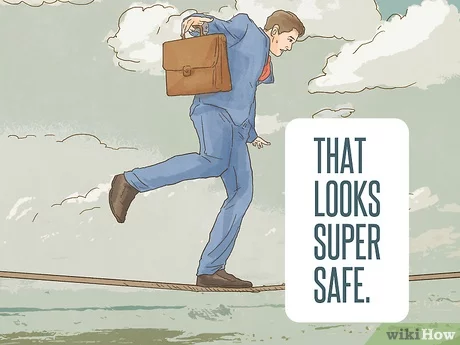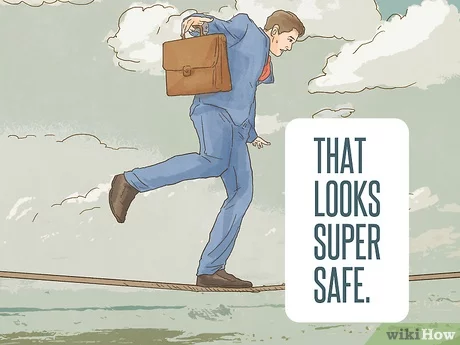

## Setup the environment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Flatten, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json
/kaggle/input/glovedata/glove.6B.200d.txt
/kaggle/input/glovedata/glove.6B.50d.txt
/kaggle/input/glovedata/glove.6B.100d.txt


**Package Version:**

* tensorflow==2.2.0
* pandas==1.0.5
* numpy==1.18.5
* google==2.0.3

## Sarcasm Detection

### Dataset
### Acknowledgement
### Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

## Load the data

### Read the json file

In [2]:
import json
data = [json.loads(line) for 
        line in open('../input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json', 'r')]

### Convert the dictionary to a dataframe

In [3]:
new_df = pd.DataFrame.from_dict(data) 

### Print few sample rows

In [4]:
new_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Drop article_link from dataset

In [5]:
new_df2 = new_df.drop(['article_link'],axis=1)

### Print few sample rows

In [6]:
new_df2.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## Get length of each headline and add a column for that

In [7]:
new_df2["headline_len"] = new_df2["headline"].str.len()

In [8]:
new_df2.head()

,headline,is_sarcastic,headline_len
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


## Initialize parameter values

* Set values for max_features, maxlen, & embedding_size
* max_features: Number of words to take from tokenizer(most frequent words)
* maxlen: Maximum length of each sentence to be limited to 25
* embedding_size: size of embedding vector

In [9]:
max_features = 10000
maxlen = 25
embedding_size = 200

## Apply tensorflow.keras Tokenizer and get indices for words
* Initialize Tokenizer object with number of words as 10000
* Fit the tokenizer object on headline column
* Convert the text to sequence

In [10]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(new_df2['headline'])

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(new_df2['headline'])

## Pad sequences

* Pad each example with a maximum length
* Convert target column into numpy array

In [13]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
X = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=maxlen)

In [14]:
Y = new_df2["is_sarcastic"].values

In [15]:
print(type(Y))

<class 'numpy.ndarray'>


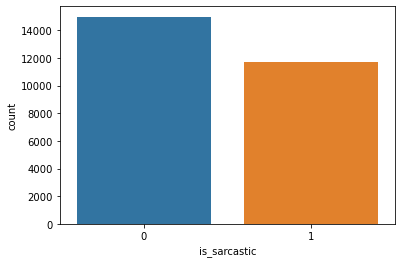

In [16]:
sns.countplot(x='is_sarcastic',data=new_df2);

### The data is fairly balanced in terms of sarcastic and non sarcastic tagging so no oversampling or undersampling required

## Vocab mapping
* There is no word for 0th index

In [17]:
tokenizer.word_index

{'<unk>': 1,
 'to': 2,
 'of': 3,
 'the': 4,
 'in': 5,
 'for': 6,
 'a': 7,
 'on': 8,
 'and': 9,
 'with': 10,
 'is': 11,
 'new': 12,
 'trump': 13,
 'man': 14,
 'from': 15,
 'at': 16,
 'about': 17,
 'you': 18,
 'this': 19,
 'by': 20,
 'after': 21,
 'up': 22,
 'out': 23,
 'be': 24,
 'how': 25,
 'as': 26,
 'it': 27,
 'that': 28,
 'not': 29,
 'are': 30,
 'your': 31,
 'his': 32,
 'what': 33,
 'he': 34,
 'all': 35,
 'just': 36,
 'who': 37,
 'has': 38,
 'will': 39,
 'more': 40,
 'one': 41,
 'into': 42,
 'report': 43,
 'year': 44,
 'why': 45,
 'have': 46,
 'area': 47,
 'over': 48,
 'donald': 49,
 'u': 50,
 'day': 51,
 'says': 52,
 's': 53,
 'can': 54,
 'first': 55,
 'woman': 56,
 'time': 57,
 'like': 58,
 'her': 59,
 "trump's": 60,
 'old': 61,
 'no': 62,
 'get': 63,
 'off': 64,
 'an': 65,
 'life': 66,
 'people': 67,
 'obama': 68,
 'now': 69,
 'house': 70,
 'still': 71,
 "'": 72,
 'women': 73,
 'make': 74,
 'was': 75,
 'than': 76,
 'white': 77,
 'back': 78,
 'my': 79,
 'i': 80,
 'clinton': 81,
 '

### Set number of words

* Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [18]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29660


## Create embedding matrix

In [19]:
EMBEDDING_FILE = '../input/glovedata/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

## Define model
### Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. In the end add a final dense layer with sigmoid activation for binary classification.

### We have not trained the embeddings generated from glove data as we are getting good results without it as well

In [20]:
lstm_out = 196

# define the model
model = Sequential()
model.add(Embedding(num_words,
                    embedding_size,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


## Compile the model

In [21]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           5932000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 392)               622496    
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 393       
Total params: 6,554,889
Trainable params: 622,889
Non-trainable params: 5,932,000
_________________________________________________________________
None


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(21367, 25) (21367,)
(5342, 25) (5342,)


## Fit the model

In [23]:
batch_size = 64
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, 
                    verbose = 1, validation_split=0.1)

Epoch 1/10
301/301 [==============================] - 66s 204ms/step - loss: 0.5935 - accuracy: 0.6665 - val_loss: 0.4353 - val_accuracy: 0.8072
Epoch 2/10
301/301 [==============================] - 61s 203ms/step - loss: 0.4744 - accuracy: 0.7668 - val_loss: 0.3824 - val_accuracy: 0.8226
Epoch 3/10
301/301 [==============================] - 63s 208ms/step - loss: 0.3976 - accuracy: 0.8148 - val_loss: 0.3419 - val_accuracy: 0.8418
Epoch 4/10
301/301 [==============================] - 65s 218ms/step - loss: 0.3505 - accuracy: 0.8442 - val_loss: 0.3220 - val_accuracy: 0.8596
Epoch 5/10
301/301 [==============================] - 66s 220ms/step - loss: 0.3394 - accuracy: 0.8483 - val_loss: 0.3091 - val_accuracy: 0.8624
Epoch 6/10
301/301 [==============================] - 68s 226ms/step - loss: 0.3085 - accuracy: 0.8651 - val_loss: 0.2972 - val_accuracy: 0.8718
Epoch 7/10
301/301 [==============================] - 65s 216ms/step - loss: 0.2964 - accuracy: 0.8719 - val_loss: 0.3011 - val_ac

## Plot the model accuracy and loss across epochs

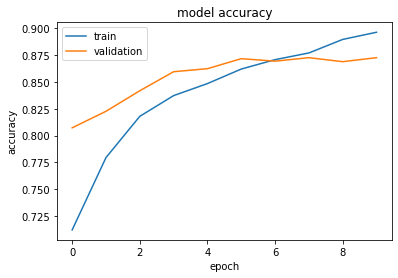

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

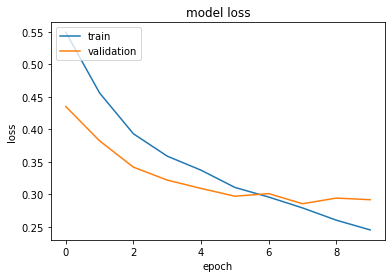

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show();

In [26]:
loss, accuracy = model.evaluate(X_test, Y_test)

167/167 [==============================] - 5s 29ms/step - loss: 0.2964 - accuracy: 0.8765


In [27]:
print(f'My test loss is {loss*100:.2f}% and test accuracy is {accuracy*100:.2f}%')

My test loss is 29.64% and test accuracy is 87.65%


## Print the confusion matrix

In [28]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


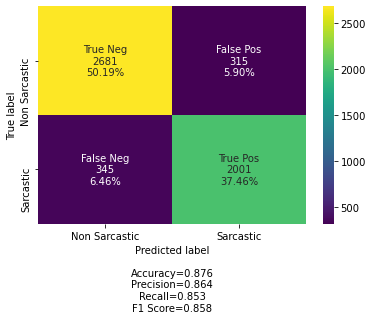

In [29]:
cf_matrix = confusion_matrix(Y_test, model.predict_classes(X_test))
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non Sarcastic','Sarcastic']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='viridis')

## Plot the ROC curve

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


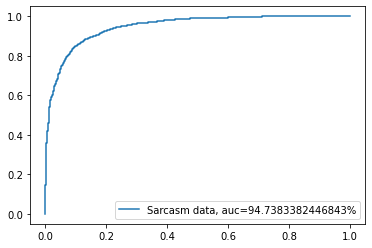

In [30]:
np.set_printoptions(precision=2)
y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Sarcasm data, auc="+str(auc*100)+"%")
plt.legend(loc=4)
plt.show();

## The model does a fairly decent job of predicting sarcastic comments with test auc of ~95%